# Exploratory Data Analysis
This notebook creates features from raw tables and visualizes the results.

## 1. Set environment
Import libraries

In [1]:
import numpy as np
import pandas as pd
from math import ceil
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from wordcloud import WordCloud, STOPWORDS
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import statsmodels.api as sm
from isodate import parse_duration
from scipy.stats import ttest_ind
from stargazer.stargazer import Stargazer

Read datasets

In [2]:
d1 = pd.read_csv('../../dat/videoDetails.csv')
d2 = pd.read_csv('../../dat/videoFlags.csv')
df = pd.merge(d1, d2, on='videoId', how='right')

## 2. Feature creation
Add constant term

In [18]:
df['const'] = 1

Convert `publishedAt` to datetime format

In [3]:
df['publishedAt'] = pd.to_datetime(df['publishedAt'], format='%Y-%m-%dT%H:%M:%SZ')

Turn `definition` to dummy

In [4]:
df['definition'] = df['definition'].replace({'sd':'0','hd':'1'}).astype(int)

Create targets from counters

In [5]:
for h in [i * 12 for i in  range(1,7)]:
    h = str(h)
    df['ncr1Post' + h] = df['post' + h + 'CommentsNeg1'] / df['post' + h + 'CommentsNum'].replace(0, 0.1)
    df['ncr2Post' + h] = df['post' + h + 'CommentsNeg2'] / df['post' + h + 'CommentsNum'].replace(0, 0.1)

Analyze most important words in video titles to create dummy variables

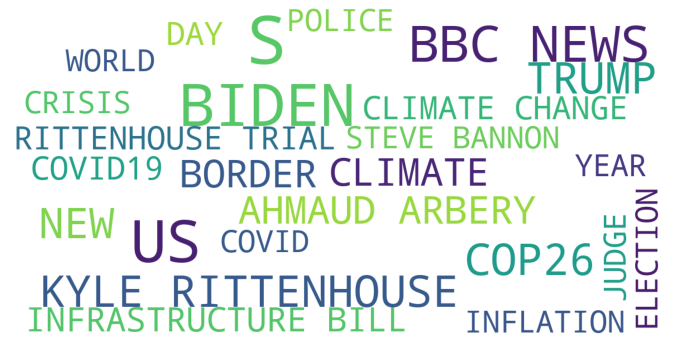

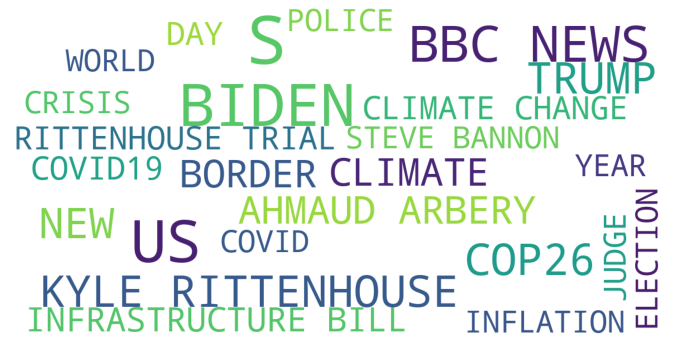

In [6]:
# All titles to single text
text = ' '.join(df['title'].str.title().tolist())

# Remove annoying strings
for string in ["'s",".","-"]:
    text = text.replace(string, '')

# All words to uppercase
text = text.upper()
# Stopwords
stopwords = set(list(STOPWORDS) + ['SAY','SAYS'])

# Plot wordcloud
wordcloud = WordCloud(
    background_color='white',
    max_words=25,
    stopwords=stopwords,
    max_font_size=40, 
    scale=3,
    random_state=42
).generate(text)

fig = plt.figure(figsize=(12, 12))
plt.axis('off')
plt.imshow(wordcloud)
plt.show()

In [7]:
# Title to lowercase
df['title'] = df['title'].str.lower()

# Dictionary of keywords
keywords = {
    'biden':['biden'],
    'trump':['trump'],
    'rittenhouse':['rittenhouse'],
    'climate':['cop26','cop 26','climate'],
    'border':['border'],
    'economy':['inflation','infrastructure'],
    'covid':['covid','covid19','covid-19'],
    'arbery':['arbery'],
    'bannon':['bannon'],
    'usa':['us','u.s','usa','u.s.a']
}

# Create Indicator variables
for topic in keywords:
    words = keywords[topic]
    df[topic] = np.where(df['title'].str.contains('|'.join(words)), 1, 0)

Video title sentiment

In [8]:
clf = SentimentIntensityAnalyzer()
df['titleSentiment'] = df['title'].apply(lambda x: clf.polarity_scores(x)['compound'])

Translate `duration` to seconds.

In [9]:
# PT format to seconds
df['seconds'] = df['duration'].apply(lambda x: int(parse_duration(x).total_seconds()))

# Convert seconds to log(seconds)
df['logSeconds'] = np.log(df['seconds'])

Sort data by upload date

In [10]:
df = df.sort_values('publishedAt', ascending=True).reset_index(drop=True)

Treatment indicator

In [11]:
df['treat'] = (df['publishedAt'] > '2021-11-10').astype(int)

Declare time (seconds) until treatment and interaction

In [203]:
# Running variable
df['r'] = (df['publishedAt'] - pd.Timestamp('2021-11-10')).dt.total_seconds()

# Interaction
df['rTreat'] = df['sut'].multiply(df['treat'])

In [205]:
df[['r','treat']]

,r,treat
0,-432000.0,0
1,-431996.0,0
2,-431975.0,0
3,-431658.0,0
4,-431168.0,0
...,...,...
1528,517634.0,1
1529,518095.0,1
1530,518125.0,1
1531,518148.0,1


## 3. EDA
List of targets

### 3.1. Descriptive statistics
Number of available videos as a function of $h$

In [14]:
# Columns to use
cols = ['post'+str(i * 12)+'CommentsNum' for i in range(1,7)]

# Merge to get videoId & posthCommentsNum
t = pd.merge(d1[['videoId','publishedAt']], d2[['videoId'] + cols], on='videoId', how='outer')

# Create C&T groups
t['treat'] = np.where(t['publishedAt'] > '2021-11-10', 1, 0)

# Count available videos per window
t[cols] = t[cols].notna().astype(int)

# Group by
t = t.groupby('treat').agg({**{'videoId':'size'}, **dict(zip(cols,['sum']*6))}).transpose()

# Format
t.index = ['Total videos'] + ['h = ' + str(i*12) for i in range(1,7)]
t

# To latex
# print(t.to_latex(caption='Number of available videos for different values of $h$',
#                  label='tab_dat_nobs'))

treat,0,1
Total videos,831,899
h = 12,678,855
h = 24,583,855
h = 36,463,855
h = 48,428,855
h = 60,344,855
h = 72,319,855


treat,0,1
Total videos,831,899
h = 12,678,855
h = 24,583,855
h = 36,463,855
h = 48,428,855
h = 60,344,855
h = 72,319,855


Balance table (conditional on 12$h$)

In [16]:
# Order dummy variables by frequency
X = ['biden','trump','rittenhouse','climate','border','economy','covid','arbery','bannon','usa']
X = df[X].mean().sort_values(ascending=False).index.tolist()

# Add remaining covariates
X = ['titleSentiment','seconds','definition'] + X

# Means by group
t = df.groupby('treat')[X].mean().transpose()

# Calculate p-values of differences
pvals = []
for x in X:
    p = ttest_ind(df.loc[df['treat'].eq(1), x], df.loc[df['treat'].eq(0), x])
    pvals.append(p[1])
t['p'] = pvals

# Change column names
t.columns = ['Control','Treatment','p-value']
t

# To latex
# print(t.to_latex(caption='Balance table for videos with comments posted within first 12 hours ('+str(len(df)) + ')',
#                  label='tab_dat_balance', float_format='%.3f'))

,Control,Treatment,p-value
titleSentiment,-0.065644,-0.087193,2.493318e-01
seconds,595.287611,642.010526,6.422882e-01
definition,0.871681,0.864327,6.733367e-01
usa,0.258112,0.283041,2.762946e-01
climate,0.061947,0.069006,5.803342e-01
biden,0.063422,0.064327,9.426537e-01
economy,0.038348,0.052632,1.865346e-01
covid,0.044248,0.038596,5.801498e-01
rittenhouse,0.010324,0.063158,1.322865e-07
trump,0.023599,0.042105,4.685110e-02


,Control,Treatment,p-value
titleSentiment,-0.065644,-0.087193,2.493318e-01
seconds,595.287611,642.010526,6.422882e-01
definition,0.871681,0.864327,6.733367e-01
usa,0.258112,0.283041,2.762946e-01
climate,0.061947,0.069006,5.803342e-01
biden,0.063422,0.064327,9.426537e-01
economy,0.038348,0.052632,1.865346e-01
covid,0.044248,0.038596,5.801498e-01
rittenhouse,0.010324,0.063158,1.322865e-07
trump,0.023599,0.042105,4.685110e-02


Balance table with discontinuous regression

$$X_i = \gamma_0 + \gamma_1 r_i + \gamma_2 T_i + \gamma_3 r_i T_i + V_i$$

In [ ]:
X = ['const','sut']
sm.OLS(endog=df['titleSentiment'], exog=df)

### 3.2. Visualizations

In [20]:
windows = ['Post' + str(h * 12) for h in range(1,7)]

Plot time series

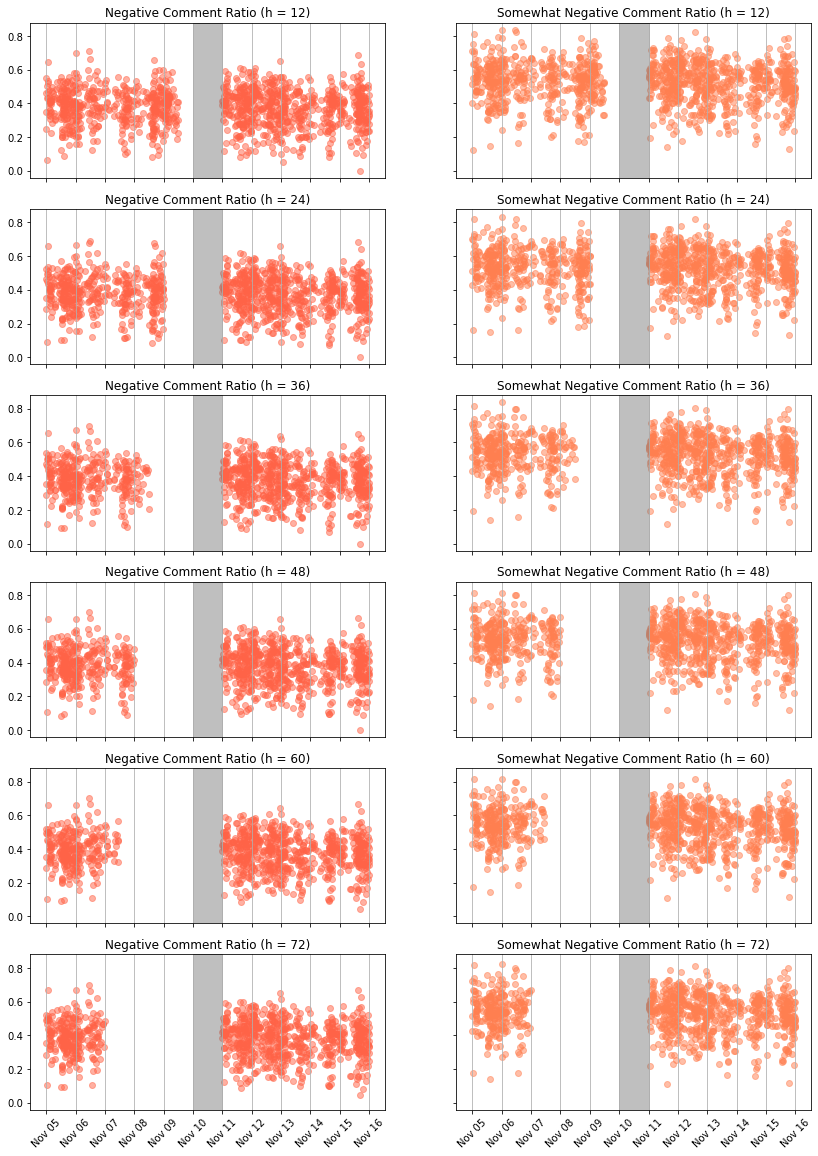

In [126]:
# ncr-like columns
cols = [col for col in df.columns if 'ncr' in col]

# Initialize figure
fig, axs = plt.subplots(nrows=6, ncols=2, sharex=True, sharey=True)
fig.set_figheight(20)
fig.set_figwidth(14)

# Plot within each axis
for i, ax in enumerate(axs.flatten()):
    # Only videos with post12CommentsNum > 15
    m = df['post12CommentsNum'].ge(15)
    # Time series
    x = df.loc[m, 'publishedAt']
    y = df.loc[m, cols[i]]
    color = 'tomato' if i % 2 == 0 else 'coral'
    ax.scatter(x, y, alpha=0.5, color=color)
    # Banned treatment region
    ax.axvspan(xmin=pd.Timestamp('2021-11-10'), xmax=pd.Timestamp('2021-11-11'),
               color='grey', alpha=0.5)
    # Ticks and labels
    ax.xaxis.set_major_locator(mdates.DayLocator(interval=1))
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))
    ax.xaxis.set_tick_params(rotation=45)
    # Aesthetics
    title = 'Negative Comment Ratio' if i % 2 == 0 else 'Somewhat Negative Comment Ratio'
    h = cols[i][-2:]
    ax.set_title(title + ' (h = ' + h + ')')
    ax.grid(which='major', axis='x')
plt.savefig('../../fig/fig_targets.png', dpi=300, bbox_inches='tight')
plt.show()

Average NCR per hourly bin

$$ncr_i = \beta_0 + \beta_1 r_i + \beta_2 r_i^2 + \beta_3 r_i^3 + T_i(\beta_4 + \beta_5 r_i + \beta_6 r_i^2 + \beta_7 r_i^3)$$

In [192]:
# Ceiling of hours until treatment
df['bin'] = df['sut'].div(3600).apply(lambda x: ceil(x))

# Average NCR
t = df[df['post12CommentsNum'].ge(15)].groupby('bin')[cols].mean()

# Columns for regression
t = t.assign(const = 1,
             r1 = t.index,
             r2 = np.power(t.index, 2),
             r3 = np.power(t.index, 3),
             t = np.where(t.index > 0, 0, 1))
t = t.assign(tr1 = t['t'].multiply(t['r1']),
             tr2 = t['t'].multiply(t['r2']),
             tr3 = t['t'].multiply(t['r3']))
t

,ncr1Post12,ncr2Post12,ncr1Post24,ncr2Post24,ncr1Post36,ncr2Post36,ncr1Post48,ncr2Post48,ncr1Post60,ncr2Post60,ncr1Post72,ncr2Post72,const,r1,r2,r3,t,tr1,tr2,tr3
bin,,,,,,,,,,,,,,,,,,,,
-143,0.359779,0.504114,0.358978,0.501141,0.361940,0.505044,0.362836,0.503852,0.367060,0.506334,0.367480,0.507782,1,-143,20449,-2924207,1,-143,20449,-2924207
-142,0.317612,0.449224,0.314770,0.450462,0.313317,0.453404,0.316635,0.457965,0.318667,0.460264,0.320184,0.460490,1,-142,20164,-2863288,1,-142,20164,-2863288
-141,0.316978,0.449709,0.317868,0.455242,0.317085,0.454327,0.317735,0.452968,0.315154,0.452332,0.317387,0.453054,1,-141,19881,-2803221,1,-141,19881,-2803221
-140,0.380888,0.496405,0.380337,0.505269,0.378714,0.505564,0.387178,0.516373,0.400562,0.525222,0.401470,0.523632,1,-140,19600,-2744000,1,-140,19600,-2744000
-139,0.344734,0.497812,0.356091,0.509529,0.358602,0.514503,0.355926,0.517191,0.355274,0.514711,0.351844,0.511729,1,-139,19321,-2685619,1,-139,19321,-2685619
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
116,0.413416,0.579903,0.404025,0.568830,0.407146,0.567727,0.412214,0.569251,0.415007,0.571750,0.415230,0.571285,1,116,13456,1560896,0,0,0,0
117,0.371973,0.515174,0.371782,0.520397,0.375512,0.532249,0.379602,0.534728,0.382985,0.536472,0.384627,0.535528,1,117,13689,1601613,0,0,0,0
118,0.385003,0.532285,0.389026,0.537515,0.390645,0.539028,0.391031,0.541577,0.391114,0.543059,0.389787,0.542005,1,118,13924,1643032,0,0,0,0


In [194]:
X = ['t','const','r1','r2','r3','tr1','tr2','tr3']
m = sm.OLS(endog=t['ncr1Post12'], exog=t[X], missing='drop')
m = m.fit()
print(m.summary())

                            OLS Regression Results                            
Dep. Variable:             ncr1Post12   R-squared:                       0.074
Model:                            OLS   Adj. R-squared:                  0.044
Method:                 Least Squares   F-statistic:                     2.413
Date:                Thu, 21 Apr 2022   Prob (F-statistic):             0.0214
Time:                        09:45:58   Log-Likelihood:                 338.68
No. Observations:                 218   AIC:                            -661.4
Df Residuals:                     210   BIC:                            -634.3
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
t              0.0434      0.079      0.548      0.5

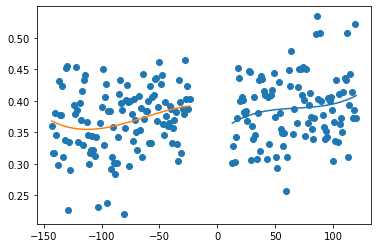

In [202]:
plt.scatter(t.index, t['ncr1Post12'])
plt.plot(m.fittedvalues[t['t'].eq(0)])
plt.plot(m.fittedvalues[t['t'].eq(1)])

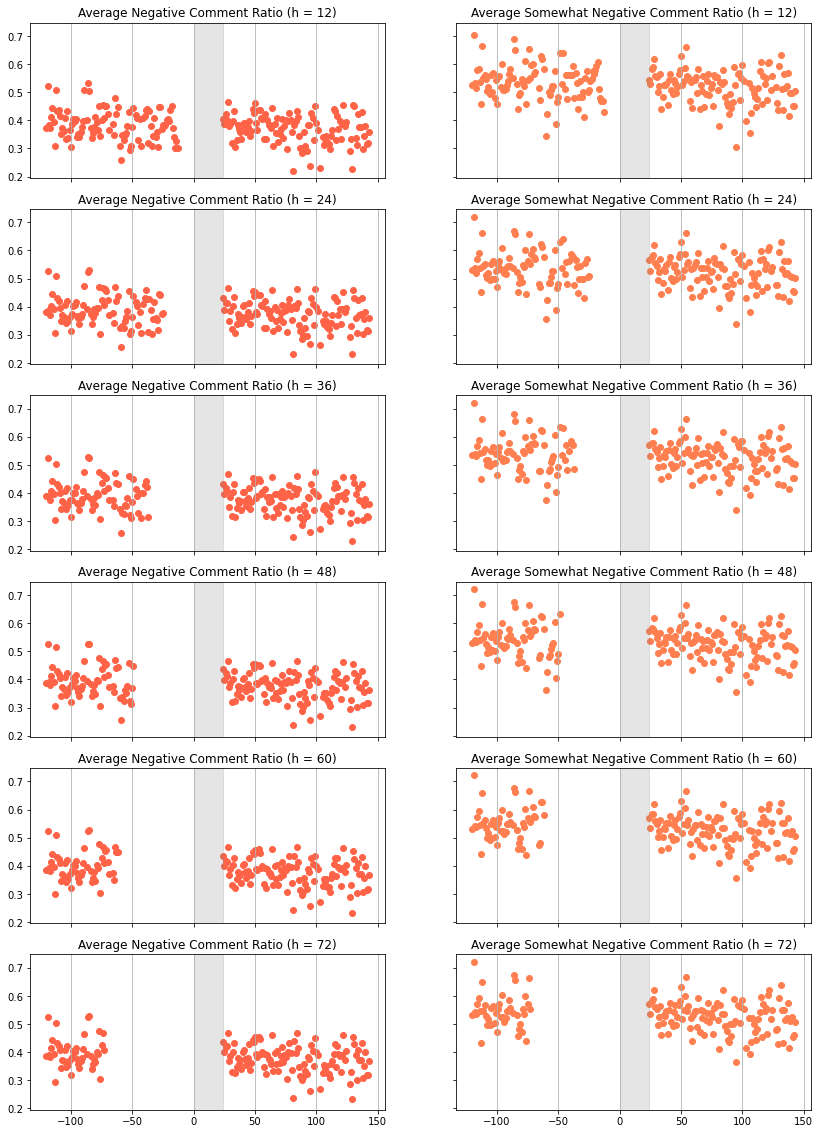

In [162]:
# Initialize figure
fig, axs = plt.subplots(nrows=6, ncols=2, sharex=True, sharey=True)
fig.set_figheight(20)
fig.set_figwidth(14)

# Plot within each axis

for i, ax in enumerate(axs.flatten()):
    # ncr1 => tomato, ncr2 => coral
    color = 'tomato' if i % 2 == 0 else 'coral'
    # Note that scatter orders x-axis in ascending order!!!
    ax.scatter(-t.index, t[t.columns[i]], color=color)
    # Banned time span
    ax.axvspan(xmin=0, xmax=24, color='gray', alpha=0.2)
    # Aesthetics
    title = 'Average Negative Comment Ratio' if i % 2 == 0 else 'Average Somewhat Negative Comment Ratio'
    h = cols[i][-2:]
    ax.set_title(f'{title} (h = {h})')
    ax.grid(which='major', axis='x')
# Export and show
plt.show()

## 4. Regression Analysis

### 4.1. No running variable

In [22]:
# List of independent variables
X = ['treat','const','logSeconds','titleSentiment','definition','biden','trump',
     'rittenhouse','climate','border','economy','covid','arbery','bannon']

# For each
for target in ['ncr1','ncr2']:
    for window in windows:
        # State case
        print(target + window)
        # First OLS model
        m0 = sm.OLS(endog=df[target + window], exog=df[X], missing='drop')
        m0_fit = m0.fit(cov_type='HC0')
        p = m0_fit.pvalues
        print(m0_fit.summary().tables[1])

        # Backwards stepwise selection
        while any(p > 0.1):
            p = m0_fit.pvalues.drop(['const','treat'])
            p = p[p > 0.1]
            if len(p) > 0:
                X.remove(p.idxmax())
                m0 = sm.OLS(endog=df[target + window], exog=df[X], missing='drop')
                m0_fit = m0.fit(cov_type='HC0')
                print('\nDropped ', p.idxmax())
                print(m0_fit.summary().tables[1])
        print('\n\n')

ncr1Post12
ncr1Post12
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
treat             -0.0142      0.008     -1.775      0.076      -0.030       0.001
const              0.1387      0.027      5.095      0.000       0.085       0.192
logSeconds         0.0219      0.003      6.413      0.000       0.015       0.029
titleSentiment    -0.0941      0.011     -8.559      0.000      -0.116      -0.073
definition         0.0768      0.020      3.824      0.000       0.037       0.116
biden              0.0164      0.010      1.565      0.118      -0.004       0.037
trump              0.0771      0.012      6.271      0.000       0.053       0.101
rittenhouse        0.1390      0.013     10.364      0.000       0.113       0.165
climate            0.0207      0.018      1.177      0.239      -0.014       0.055
border             0.0087      0.020      0.439      0.660      -

                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
treat             -0.0142      0.008     -1.775      0.076      -0.030       0.001
const              0.1387      0.027      5.095      0.000       0.085       0.192
logSeconds         0.0219      0.003      6.413      0.000       0.015       0.029
titleSentiment    -0.0941      0.011     -8.559      0.000      -0.116      -0.073
definition         0.0768      0.020      3.824      0.000       0.037       0.116
biden              0.0164      0.010      1.565      0.118      -0.004       0.037
trump              0.0771      0.012      6.271      0.000       0.053       0.101
rittenhouse        0.1390      0.013     10.364      0.000       0.113       0.165
climate            0.0207      0.018      1.177      0.239      -0.014       0.055
border             0.0087      0.020      0.439      0.660      -0.030       0.047
econ

### 4.1. Linear f
$NCR_i = \beta_0 + \beta_1 T_i + \beta_2 R_i + \beta_3 T_i \times R_i + \beta_4 Sentiment_i + u_i$

In [23]:
X = ['treat','sut','treatSut','const','titleSentiment']
m = df['post12CommentsNum'] > 0
models = []
for target in ['ncr1','ncr2']:
    for window in windows:
        m0 = sm.OLS(endog=df.loc[m, target+window], exog=df.loc[m, X], missing='drop')
        m0 = m0.fit(cov_type='HC0')
        models.append(m0)
        print(target + window, round(m0.rsquared, 3))
        print(m0.summary().tables[1], '\n\n')

ncr1Post12 0.063
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
treat              0.0351      0.018      1.957      0.050   -5.67e-05       0.070
sut             6.441e-08   4.72e-08      1.365      0.172   -2.81e-08    1.57e-07
treatSut        2.516e-08   6.11e-08      0.412      0.680   -9.46e-08    1.45e-07
const              0.3264      0.013     24.806      0.000       0.301       0.352
titleSentiment    -0.1079      0.011    -10.021      0.000      -0.129      -0.087


ncr1Post24 0.066
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
treat              0.0393      0.021      1.870      0.061      -0.002       0.080
sut             6.888e-08   5.69e-08      1.211      0.226   -4.26e-08     1.8e-07
treatSut        2.035e-08   6.82e-08      0.299    

ncr1Post12 0.063
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
treat              0.0351      0.018      1.957      0.050   -5.67e-05       0.070
sut             6.441e-08   4.72e-08      1.365      0.172   -2.81e-08    1.57e-07
treatSut        2.516e-08   6.11e-08      0.412      0.680   -9.46e-08    1.45e-07
const              0.3264      0.013     24.806      0.000       0.301       0.352
titleSentiment    -0.1079      0.011    -10.021      0.000      -0.129      -0.087


ncr1Post24 0.066
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
treat              0.0393      0.021      1.870      0.061      -0.002       0.080
sut             6.888e-08   5.69e-08      1.211      0.226   -4.26e-08     1.8e-07
treatSut        2.035e-08   6.82e-08      0.299    

In [24]:
ncr1 = Stargazer(models[:6])
ncr1.dependent_variable_name('Dependent Variable: Negative Comment Ratio')
ncr1.custom_columns(['h = ' + str(i*12) for i in range(1,7)], [1]*6)
ncr1.covariate_order(['treat','treatSut','sut','titleSentiment','const'])
ncr1.show_degrees_of_freedom(False)
ncr1.add_custom_notes(['Robust standard errors (HC0)'])
ncr1

In [26]:
# print(ncr1.render_latex())

In [27]:
ncr2 = Stargazer(models[6:])
ncr2.dependent_variable_name('Dependent Variable: Somewhat Negative Comment Ratio')
ncr2.custom_columns(['h = ' + str(i*12) for i in range(1,7)], [1]*6)
ncr2.covariate_order(['treat','treatSut','sut','titleSentiment','const'])
ncr2.show_degrees_of_freedom(False)
ncr2.add_custom_notes(['Robust standard errors (HC0)'])
ncr2

In [28]:
# print(ncr2.render_latex())

### 4.3 Linrear f(r) with backwards selection

In [ ]:
# Covariates
X = ['treat','sut','treatSut','const',
      'definition','logSeconds','titleSentiment','biden','trump','rittenhouse',
      'climate','border', 'economy', 'covid', 'arbery', 'bannon', 'usa']

# Backwards Elim
m = df['post12CommentsNum'] > 0
for target in ['ncr1Post12','ncr2Post12']:
    print('\n'+target+'\n')
    # Fit model
    m0 = sm.OLS(endog=df.loc[m, target], exog=df.loc[m, X])
    m0_fit = m0.fit(cov_type='HC0')
    print('All covariates\n', m0_fit.summary().tables[1], sep='')
    # Get p-values
    p = m0_fit.pvalues.drop(['treat','sut','treatSut','const'])
    # Backwards iteration
    while any(p > 0.05):
        # Drop least significant control
        print('Dropped', p.idxmax())
        p = p.drop(p.idxmax())
        # Survivors
        X = ['treat','sut','treatSut','const'] + p.index.to_list()
        # Fit model
        m0 = sm.OLS(endog=df.loc[m, target], exog=df.loc[m, X])
        m0_fit = m0.fit(cov_type='HC0')
        print(m0_fit.summary().tables[1], '\n')
        # Get p-values
        p = m0_fit.pvalues.drop(['treat','sut','treatSut','const'])